In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


DATASETS_PATH = '/content/drive/My Drive/Datasets/ML Project/data/recommended'
TRAINING_PATH = f'{DATASETS_PATH}/training/training.csv'
TESTING_PATH = f'{DATASETS_PATH}/test/test.csv'
INDEX_COL = 'pkSeqID'
BEST_FEATURE_ORDER = [
  'seq', 'min', 'max', 'mean', 'stddev',
  'N_IN_Conn_P_SrcIP', 'N_IN_Conn_P_DstIP',
  'drate', 'srate',
  'saddr', 'sport', 'daddr', 'dport', 'proto',
  'state_number',
  'attack', 'category', 'subcategory'
]

In [82]:
training = pd.read_csv(TRAINING_PATH, index_col=INDEX_COL)[BEST_FEATURE_ORDER]
training.head()

,seq,min,max,mean,stddev,N_IN_Conn_P_SrcIP,N_IN_Conn_P_DstIP,drate,srate,saddr,sport,daddr,dport,proto,state_number,attack,category,subcategory
pkSeqID,,,,,,,,,,,,,,,,,,
3142762,251984,0.000000,4.031619,2.687519,1.900363,100,100,0.0,0.494549,192.168.100.150,6551,192.168.100.3,80,udp,4,1,DDoS,UDP
2432264,256724,3.856930,4.012924,3.934927,0.078003,38,100,0.0,0.256493,192.168.100.150,5532,192.168.100.3,80,tcp,3,1,DDoS,TCP
1976315,62921,2.974100,3.609205,3.341429,0.268666,100,100,0.0,0.294880,192.168.100.147,27165,192.168.100.3,80,tcp,3,1,DDoS,TCP
1240757,99168,0.000000,4.942302,3.222832,1.823185,63,63,0.0,0.461435,192.168.100.150,48719,192.168.100.3,80,udp,4,1,DoS,UDP
3257991,105063,2.979995,4.994452,3.983222,0.822418,100,100,0.0,1.002999,192.168.100.147,22461,192.168.100.3,80,udp,4,1,DDoS,UDP


In [83]:
testing = pd.read_csv(TESTING_PATH, index_col=INDEX_COL)[BEST_FEATURE_ORDER]

In [47]:
print(f'Training Shape: {training.shape}')
print(f'Testing Shape: {testing.shape}')

Training Shape: (2934817, 18)
Testing Shape: (733705, 18)


In [48]:
training.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2934817 entries, 3142762 to 96906
Data columns (total 18 columns):
 #   Column             Dtype  
---  ------             -----  
 0   seq                int64  
 1   min                float64
 2   max                float64
 3   mean               float64
 4   stddev             float64
 5   N_IN_Conn_P_SrcIP  int64  
 6   N_IN_Conn_P_DstIP  int64  
 7   drate              float64
 8   srate              float64
 9   saddr              object 
 10  sport              object 
 11  daddr              object 
 12  dport              object 
 13  proto              object 
 14  state_number       int64  
 15  attack             int64  
 16  category           object 
 17  subcategory        object 
dtypes: float64(6), int64(5), object(7)
memory usage: 425.4+ MB


In [49]:
import numpy as np

numerical = [training.columns[i] for i in range(len(training.columns)) if training.dtypes.iloc[i] != 'O']
non_numerical = [training.columns[i] for i in range(len(training.columns)) if training.dtypes.iloc[i] == 'O']

print(f'There are {len(numerical)} numerical features, and {len(non_numerical)} non numerical features')

There are 11 numerical features, and 7 non numerical features


In [50]:
training.isna().sum(axis=0)

,0
seq,0
min,0
max,0
mean,0
stddev,0
N_IN_Conn_P_SrcIP,0
N_IN_Conn_P_DstIP,0
drate,0
srate,0
saddr,0


In [51]:
sum(training.duplicated())

0

Dataset has no duplicated rows, or missing values.

In [52]:
training.head()

,seq,min,max,mean,stddev,N_IN_Conn_P_SrcIP,N_IN_Conn_P_DstIP,drate,srate,saddr,sport,daddr,dport,proto,state_number,attack,category,subcategory
pkSeqID,,,,,,,,,,,,,,,,,,
3142762,251984,0.000000,4.031619,2.687519,1.900363,100,100,0.0,0.494549,192.168.100.150,6551,192.168.100.3,80,udp,4,1,DDoS,UDP
2432264,256724,3.856930,4.012924,3.934927,0.078003,38,100,0.0,0.256493,192.168.100.150,5532,192.168.100.3,80,tcp,3,1,DDoS,TCP
1976315,62921,2.974100,3.609205,3.341429,0.268666,100,100,0.0,0.294880,192.168.100.147,27165,192.168.100.3,80,tcp,3,1,DDoS,TCP
1240757,99168,0.000000,4.942302,3.222832,1.823185,63,63,0.0,0.461435,192.168.100.150,48719,192.168.100.3,80,udp,4,1,DoS,UDP
3257991,105063,2.979995,4.994452,3.983222,0.822418,100,100,0.0,1.002999,192.168.100.147,22461,192.168.100.3,80,udp,4,1,DDoS,UDP


In [53]:
training['saddr'].value_counts()

,count
saddr,
192.168.100.147,761360
192.168.100.148,738642
192.168.100.150,712260
192.168.100.149,711466
192.168.100.3,6609
192.168.100.5,4107
192.168.100.6,272
192.168.100.7,34
192.168.100.4,17


Most of the source addresses are for a local network, so they are not that much useful in a real-world scenario

**Conclusion:**
`saddr` probably should be dropped

In [54]:
TO_DROP = ['saddr']

In [55]:
training['daddr'].value_counts()

,count
daddr,
192.168.100.3,1900562
192.168.100.5,361192
192.168.100.7,332161
192.168.100.6,329679
192.168.100.150,3040
...,...
205.251.194.167,1
224.0.0.252,1
216.239.38.10,1


In [56]:
non_local_addr = training.loc[training['daddr'].map(lambda addr: not str(addr).startswith('192.168')), 'daddr']
l_non_local = len(non_local_addr)
l_local = len(training['daddr']) - l_non_local
print(f"Non-Local to Local ratio: {l_non_local} / {l_local} = {l_non_local / l_local}")
non_local_addr.value_counts()

Non-Local to Local ratio: 242 / 2934575 = 8.246509290101632e-05


,count
daddr,
8.8.8.8,48
224.0.0.251,42
27.124.125.250,12
ff02::fb,7
ff02::2,6
...,...
205.251.194.167,1
224.0.0.252,1
216.239.38.10,1


A high number of destination addresses are from a local network, likely not to occur in real world scenario.

**Conclusion:** `daddr` is to dropped

In [57]:
TO_DROP = TO_DROP + ['daddr']
print(TO_DROP)

['saddr', 'daddr']


In [58]:
training.head()

,seq,min,max,mean,stddev,N_IN_Conn_P_SrcIP,N_IN_Conn_P_DstIP,drate,srate,saddr,sport,daddr,dport,proto,state_number,attack,category,subcategory
pkSeqID,,,,,,,,,,,,,,,,,,
3142762,251984,0.000000,4.031619,2.687519,1.900363,100,100,0.0,0.494549,192.168.100.150,6551,192.168.100.3,80,udp,4,1,DDoS,UDP
2432264,256724,3.856930,4.012924,3.934927,0.078003,38,100,0.0,0.256493,192.168.100.150,5532,192.168.100.3,80,tcp,3,1,DDoS,TCP
1976315,62921,2.974100,3.609205,3.341429,0.268666,100,100,0.0,0.294880,192.168.100.147,27165,192.168.100.3,80,tcp,3,1,DDoS,TCP
1240757,99168,0.000000,4.942302,3.222832,1.823185,63,63,0.0,0.461435,192.168.100.150,48719,192.168.100.3,80,udp,4,1,DoS,UDP
3257991,105063,2.979995,4.994452,3.983222,0.822418,100,100,0.0,1.002999,192.168.100.147,22461,192.168.100.3,80,udp,4,1,DDoS,UDP


In [59]:
training.describe()

,seq,min,max,mean,stddev,N_IN_Conn_P_SrcIP,N_IN_Conn_P_DstIP,drate,srate,state_number,attack
count,2.934817e+06,2.934817e+06,2.934817e+06,2.934817e+06,2.934817e+06,2.934817e+06,2.934817e+06,2.934817e+06,2.934817e+06,2.934817e+06,2.934817e+06
mean,1.212973e+05,1.017208e+00,3.019269e+00,2.230471e+00,8.869639e-01,8.254997e+01,9.245766e+01,4.303064e-01,3.128290e+00,3.134219e+00,9.998739e-01
std,7.578700e+04,1.483551e+00,1.860915e+00,1.517766e+00,8.036391e-01,2.439019e+01,1.816651e+01,5.623304e+01,7.845494e+02,1.187107e+00,1.122750e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,5.484700e+04,0.000000e+00,2.804170e-01,1.819340e-01,2.999700e-02,6.900000e+01,1.000000e+02,0.000000e+00,1.558450e-01,3.000000e+00,1.000000e+00
50%,1.177370e+05,0.000000e+00,4.008429e+00,2.689973e+00,7.925750e-01,1.000000e+02,1.000000e+02,0.000000e+00,2.837800e-01,4.000000e+00,1.000000e+00
75%,1.848700e+05,2.147949e+00,4.292426e+00,3.565061e+00,1.745220e+00,1.000000e+02,1.000000e+02,0.000000e+00,4.880000e-01,4.000000e+00,1.000000e+00
max,2.622110e+05,4.980471e+00,4.999999e+00,4.981882e+00,2.496763e+00,1.000000e+02,1.000000e+02,5.882353e+04,1.000000e+06,1.100000e+01,1.000000e+00


The `seq` column is defined as the Argus (an open-source tool used as a data source for an **ML for anamoly detection** use case).

Since this model is meant to be general and the `seq` doesn't carry any useful information it should be dropped.

In [60]:
TO_DROP += ['seq']

In [61]:
training.head()

,seq,min,max,mean,stddev,N_IN_Conn_P_SrcIP,N_IN_Conn_P_DstIP,drate,srate,saddr,sport,daddr,dport,proto,state_number,attack,category,subcategory
pkSeqID,,,,,,,,,,,,,,,,,,
3142762,251984,0.000000,4.031619,2.687519,1.900363,100,100,0.0,0.494549,192.168.100.150,6551,192.168.100.3,80,udp,4,1,DDoS,UDP
2432264,256724,3.856930,4.012924,3.934927,0.078003,38,100,0.0,0.256493,192.168.100.150,5532,192.168.100.3,80,tcp,3,1,DDoS,TCP
1976315,62921,2.974100,3.609205,3.341429,0.268666,100,100,0.0,0.294880,192.168.100.147,27165,192.168.100.3,80,tcp,3,1,DDoS,TCP
1240757,99168,0.000000,4.942302,3.222832,1.823185,63,63,0.0,0.461435,192.168.100.150,48719,192.168.100.3,80,udp,4,1,DoS,UDP
3257991,105063,2.979995,4.994452,3.983222,0.822418,100,100,0.0,1.002999,192.168.100.147,22461,192.168.100.3,80,udp,4,1,DDoS,UDP


In [84]:
training.drop(TO_DROP, axis=1, inplace=True)
testing.drop(TO_DROP, axis=1, inplace=True)

In [63]:
training['category'].value_counts()

,count
category,
DDoS,1541315
DoS,1320148
Reconnaissance,72919
Normal,370
Theft,65


In [64]:
training['subcategory'].value_counts()

,count
subcategory,
UDP,1584650
TCP,1274843
Service_Scan,58626
OS_Fingerprint,14293
HTTP,1970
Normal,370
Keylogging,59
Data_Exfiltration,6


Since the `subcategory` column also contains useful information about the type of attack it is useful to keep it as a target so
it is reasonable to have a single column combining both `category` and `subcategory`

In [85]:
def process_target(r):
  if str(r['category']).lower() == 'theft':
    return r['category']
  return r['category'] + ' ' + r['subcategory']

In [86]:
training['category'] = training.apply(process_target, axis=1)
training['category'].value_counts()

In [ ]:
testing['category'] = training.apply(process_target, axis=1)
testing['category'].value_counts()

In [88]:
training.drop('subcategory', axis=1, inplace=True)
testing.drop('subcategory', axis=1, inplace=True)

In [89]:
training['category'].value_counts()

,count
category,
DoS UDP,826349
DDoS TCP,782228
DDoS UDP,758301
DoS TCP,492615
Reconnaissance Service_Scan,58626
Reconnaissance OS_Fingerprint,14293
DoS HTTP,1184
DDoS HTTP,786
Normal Normal,370


In [90]:
category_counts = training['category'].value_counts()
(category_counts / category_counts.max()) * 100

,count
category,
DoS UDP,100.000000
DDoS TCP,94.660731
DDoS UDP,91.765223
DoS TCP,59.613432
Reconnaissance Service_Scan,7.094581
Reconnaissance OS_Fingerprint,1.729657
DoS HTTP,0.143281
DDoS HTTP,0.095117
Normal Normal,0.044775


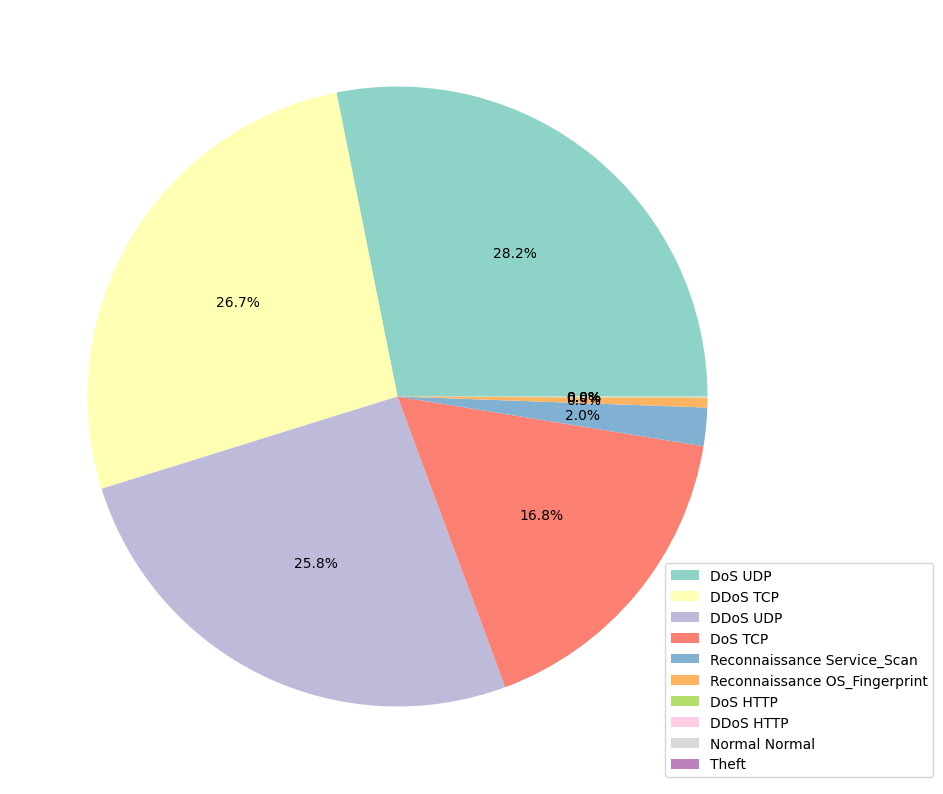

In [91]:
plt.figure(figsize=(10, 14))
colors = plt.cm.Set3(range(len(category_counts)))  # or use custom colors
plt.pie(category_counts, labels=None, colors=colors, autopct='%1.1f%%')
plt.legend(category_counts.index, loc='lower right', bbox_to_anchor=(1.2, 0))
plt.show()

We also notice that the data is very skewed when it comes to attack types (`Theft Data_Exfiltration` is 0.0007% of the amount of `DDoS UDP` attack instances)
This is something that needs to be addressed or the results might be missleading.